In [1]:
import torch
import numpy as np
%load_ext autoreload
%autoreload 2
from utils1 import load_data,default_loader,trainset,imshow,normal,layershow
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torchsummary import summary
import time,datetime
from scipy.integrate import solve_ivp
from bokeh.io import  output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.models import Label
from ipywidgets import interact, FloatSlider
from bokeh.palettes import Category10, Category20
output_notebook(hide_banner=True)

**Data Path**

In [2]:
datapath = "./datasets"
datapath = "/home/tete/data/Youtube"
data,paths,labels = load_data(datapath)
available_field = ['url','videoname','locs','frameids','label_names','crop','scale','origRes','isYouTubeSubset']


**shift the data**

In [3]:
num_data=len(paths)
index=np.arange(num_data)
np.random.shuffle(index)
paths=[paths[i] for i in index]
labels=[labels[i] for i in index]

**partition of the data into three part**

In [7]:
#how many data we will put into each set
train_num,val_num, test_num  = int(0.8*num_data),int(num_data*0.1),int(num_data*0.1)
new_w,new_h=224,224

assert(train_num+val_num+test_num<=num_data)
train_path,train_label=paths[0:train_num],labels[0:train_num]
val_path,  val_label  =paths[train_num:train_num+val_num],labels[train_num:train_num+val_num]
test_path, test_label =paths[train_num+val_num:],labels[train_num+val_num:]

bc=8

train_data  = trainset(train_path,train_label,new_w,new_h)
trainloader = DataLoader(train_data, batch_size=bc,shuffle=True)

val_data  = trainset(val_path,val_label,new_w,new_h)
valloader = DataLoader(val_data, batch_size=bc,shuffle=True)

test_data  = trainset(test_path,test_label,new_w,new_h)
testloader = DataLoader(test_data, batch_size=bc,shuffle=True)
print("number of data in the training set    :", len(train_data))
print("number of data in the validation set  :", len(val_data))
print("number of data in the test set        :", len(test_data))

number of data in the training set    : 4000
number of data in the validation set  : 500
number of data in the test set        : 500


In [8]:
train_data[0][1]

tensor([[114.4151,  83.5699],
        [ 91.0577, 106.4219],
        [118.7178, 163.9286],
        [ 78.7643, 147.8569],
        [144.5338, 165.9376],
        [ 95.9750, 118.9779],
        [133.6747, 118.2246]])

**load example data from test set**

In [9]:
count = 1
for data in testloader:
    if count == 1:
        inputs_try,labels_try = data
    count +=1
print(count,"batches")   
print(inputs_try.shape)
print(labels_try.shape)

64 batches
torch.Size([8, 3, 224, 224])
torch.Size([8, 7, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


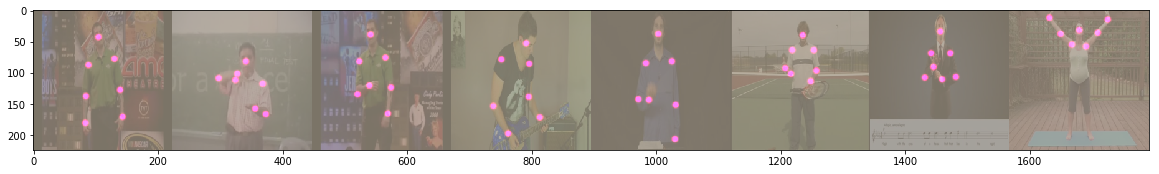

In [10]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,[224,224],labels_try) 

In [11]:
use_gpu=torch.cuda.is_available()
use_gpu

True

In [55]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            #nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),  
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1), 
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            
            
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
            
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
            
            
            nn.Conv2d(256, 512, 3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, stride=2),
            
        )
        self.drop1=nn.Dropout(p=0.5)
        self.fn1=nn.Linear(int(512*7*7/2),7)
        #self.fn1=nn.Linear(1024,7)
    def forward(self, x):
        x=self.seq(x)
        x=x.view(-1,2,int(512*7*7/2))
        x=self.drop1(x)
        x=self.fn1(x)
        x=x.reshape(-1,7,2)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Regressor().to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
       BatchNorm2d-3         [-1, 16, 224, 224]              32
            Conv2d-4         [-1, 32, 224, 224]           4,640
              ReLU-5         [-1, 32, 224, 224]               0
            Conv2d-6         [-1, 32, 224, 224]           9,248
              ReLU-7         [-1, 32, 224, 224]               0
       BatchNorm2d-8         [-1, 32, 224, 224]              64
         MaxPool2d-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]          18,496
             ReLU-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,928
             ReLU-13         [-1, 64, 112, 112]               0
      BatchNorm2d-14         [-1, 64, 1

In [56]:
512*7*7/2

12544.0

In [57]:
model_res = torchvision.models.resnet152(pretrained=True )

In [58]:
model_res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [59]:
model_res.fc = Regressor()

In [65]:
def train(model,trainloader,loss_fn,optimizer):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    optimizer = optimizer

    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    for data in trainloader:
        inputs, labels = data
        bs = labels.size(0)

        if use_gpu:
            inputs=inputs.cuda()
            labels=labels.cuda()


        outputs = model(inputs)

        loss = loss_fn(outputs,labels) 
        
        sum_loss = torch.sum(loss,dim=2)
        sqrt_loss = torch.sqrt(sum_loss)
        sum_loss2 = torch.sum(sqrt_loss)
        
        optimizer.zero_grad()
        sum_loss2.backward()
        optimizer.step()

        #running_loss+=loss.data.item()
        #_,preds = torch.max(outputs.data,1)
        preds=outputs.data
        # statistics
        running_loss += sum_loss2.data.item()
        #print(preds.shape,labels.shape)
        #running_corrects += torch.sum(preds == labels)

        if(size%int(len(trainloader)/5)==0 and size!=0):
            print(running_loss / size, size)
        size += bs
              
            
    epoch_loss = running_loss / size

    #acc_train[epoch_num] = epoch_acc
    #print( 'Train - Loss: {:.4f}'.format(epoch_loss))
        
    return epoch_loss


In [66]:
plot_distance = 125
labels = ['Head', 'Right wrist', 'Left wrist', 'Right elbow', 'Left elbow', 'Right shoulder', 'Left shoulder']
def print_figure(distance):
    fig_sol = figure(x_range=(0, plot_distance), width=650, height=300, title="Solution")
    for i in range(7):
        d = distance[:,i]
        length_d = len(d)
        np.append(d,[plot_distance])
        counter = 0
        acc = []
        for j in range(plot_distance):
            while(counter<length_d and d[counter]<j):
                counter = counter+1
            acc.append(1.0*counter/length_d)
        fig_sol.line(range(plot_distance),acc,legend=labels[i],line_width=2,color=Category10[10][i])
    fig_sol.legend.location = "bottom_right"
    show(fig_sol)
            

In [67]:
def test(model,data_loader,loss_fn,optimizer):
    model.eval()
    if use_gpu:
        model=model.to("cuda")
    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    distance = []
    with torch.no_grad():

        for data in data_loader:
            inputs, labels = data    
            bs = labels.size(0)

            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()
                
            outputs = model(inputs)
            
            loss = loss_fn(outputs,labels)
            
            sum_loss = torch.sum(loss,dim=2)
            sqrt_loss = torch.sqrt(sum_loss)
            distance.extend(sqrt_loss.cpu().numpy())
            
            sum_loss2 = torch.sum(sqrt_loss)
            #print(ave_loss.shape)
            #running_loss+=loss.data.item()
            #_,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += sum_loss2.data.item()
            #running_corrects += torch.sum(preds == labels)
            size += bs
        
        out = torchvision.utils.make_grid(inputs_try.cpu(),padding=0)
        preds=model(inputs_try.cuda()).cpu()
        imshow(out,[224,224],preds.cpu())
        
        epoch_loss = running_loss / size
    distance = np.array(distance)
    distance.sort(axis=0)
   #print(distance[:,0])
    print_figure(distance)
    return epoch_loss

In [68]:
pose_detection = Regressor()
# choose the appropriate loss
loss_fn = nn.MSELoss(reduction='none')
#loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1.0
# your SGD optimizer
#optimizer_cl = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)

# parameters = []
# parameters.append({ "params": pose_detection.fc.parameters()})
# parameters.append({ "params": pose_detection.layer4.parameters()})

optimizer = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# and train for 10 epochs
l_t,l_v=[],[]

79.68648086547852 200
76.49200843811035 400
76.35258880615234 600
76.89494846343995 800
76.71193548583985 1000
76.04167304992676 1200
76.43162471226283 1400
76.30072799682617 1600
77.04528762817382 1800
76.65135302734375 2000
76.81589010065252 2200
76.85829921722411 2400
76.85477570753831 2600
76.29878608703613 2800
76.34227941894531 3000
76.35945088386535 3200
76.13309466193704 3400
76.21087561713324 3600
76.1739931367573 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


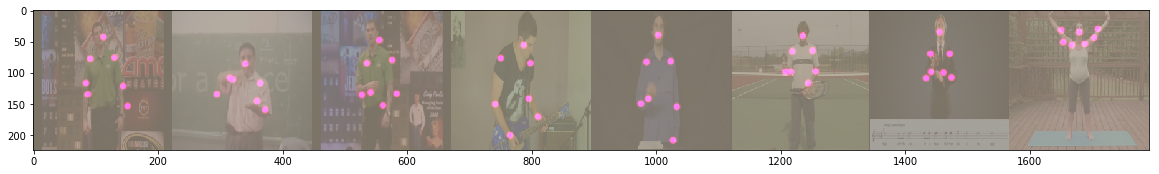

Epoch: 1  Train - Loss: 75.86 ; Validation - Loss: 65.98
Time consumed: 0:00:59.690076 Remaining time: 0:08:57.210685
78.5478384399414 200
78.14135437011718 400
77.29205485026041 600
77.32169151306152 800
77.49754193115234 1000
77.09652608235677 1200
76.65890036446707 1400
76.96569347381592 1600
76.86123631795247 1800
76.5561376953125 2000
76.51779502175071 2200
76.33491746266682 2400
76.67535042395959 2600
76.60064205714635 2800
76.43193713378906 3000
76.23343126296997 3200
76.05250859877643 3400
75.87375173780653 3600
75.8069277632864 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


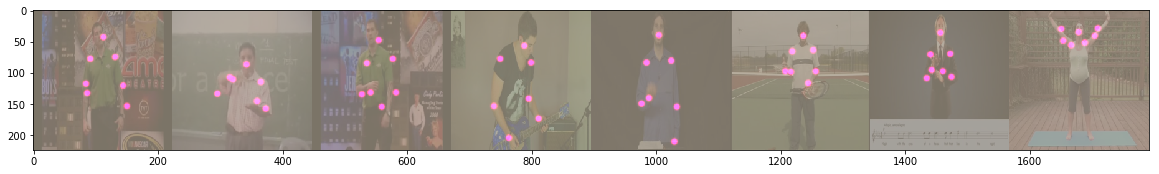

Epoch: 2  Train - Loss: 75.56 ; Validation - Loss: 65.88
Time consumed: 0:01:58.970914 Remaining time: 0:07:55.883656
75.73176879882813 200
75.0580005645752 400
73.95148356119792 600
73.436318359375 800
74.43556680297851 1000
74.4428520711263 1200
74.08376804896763 1400
74.44229763031007 1600
74.27581161499023 1800
74.57101443481446 2000
74.84428045099432 2200
75.30172074635824 2400
75.35897121722881 2600
75.44561113630023 2800
75.25685823567709 3000
75.47957724571228 3200
75.60533410465015 3400
75.57347554524739 3600
75.6513480417352 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


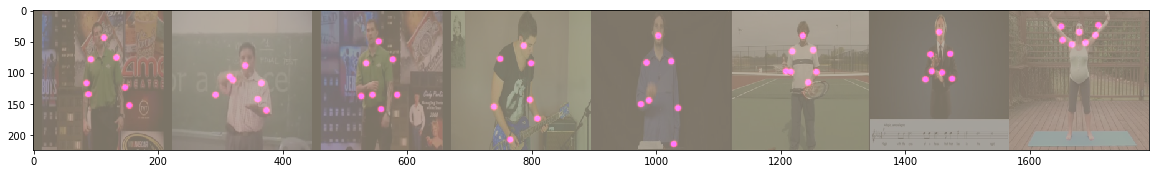

Epoch: 3  Train - Loss: 75.28 ; Validation - Loss: 65.28
Time consumed: 0:02:58.295943 Remaining time: 0:06:56.023866
79.09210739135742 200
77.26815391540528 400
76.8376851908366 600
74.45538852691651 800
74.97772830200195 1000
75.31606839497884 1200
75.3371760559082 1400
74.90721035003662 1600
74.49299229939778 1800
74.9146104888916 2000
74.98282215465198 2200
74.8171487045288 2400
74.7595825430063 2600
74.80083206176758 2800
74.855744140625 3000
75.11672827720642 3200
75.13013538136202 3400
74.91570543924968 3600
74.93652354993318 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


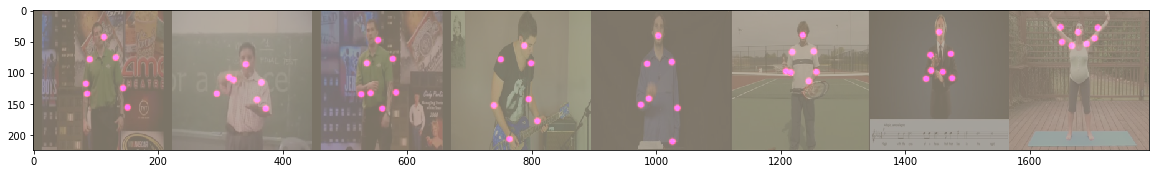

Epoch: 4  Train - Loss: 74.82 ; Validation - Loss: 65.26
Time consumed: 0:03:57.682251 Remaining time: 0:05:56.523376
77.03208389282227 200
77.5157462310791 400
76.45758336385092 600
75.88791564941407 800
75.38911911010742 1000
75.9583846282959 1200
76.35431729997907 1400
76.05913120269776 1600
75.2506194390191 1800
75.25928749084473 2000
74.82003477616743 2200
74.6909404373169 2400
74.67341404841497 2600
74.52790788922991 2800
74.65676653035482 3000
74.70221571922302 3200
75.0709911660587 3400
75.09056387159559 3600
74.79380124543843 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


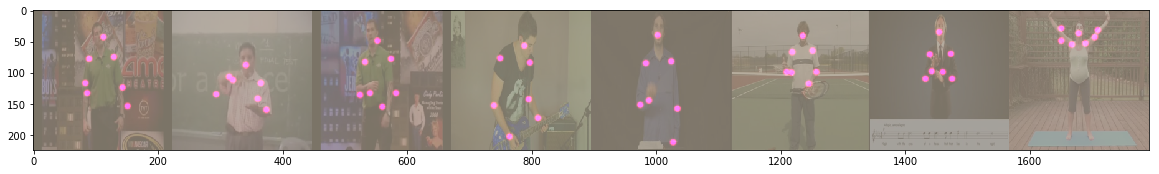

Epoch: 5  Train - Loss: 74.64 ; Validation - Loss: 64.94
Time consumed: 0:04:57.016974 Remaining time: 0:04:57.016974
74.94633575439452 200
75.93498062133789 400
76.1734141031901 600
76.88205257415771 800
75.65104397583008 1000
75.2837119547526 1200
74.79208254132952 1400
74.4602149963379 1600
74.72428548177083 1800
74.68196775817871 2000
74.77406244451349 2200
74.55687099456787 2400
74.42160939143254 2600
74.6347599356515 2800
74.62553624471029 3000
74.3311164855957 3200
74.50085810941809 3400
74.5354184044732 3600
74.34237847579153 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


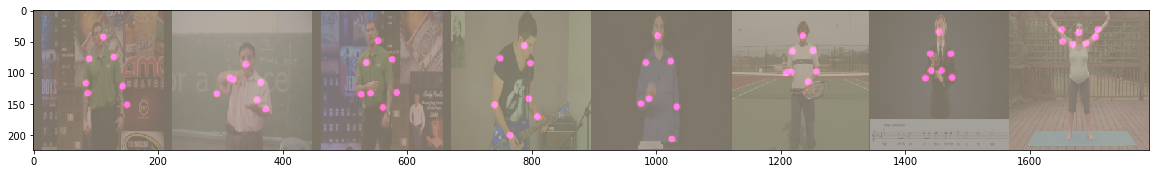

Epoch: 6  Train - Loss: 74.11 ; Validation - Loss: 65.16
Time consumed: 0:05:56.345678 Remaining time: 0:03:57.563785
75.78062103271485 200
74.23800514221192 400
74.06886510213216 600
74.12548954010009 800
74.26964221191406 1000
74.69818428039551 1200
74.93197058541435 1400
74.53880285263061 1600
74.63358052571614 1800
74.9569171295166 2000
74.65976237903942 2200
74.30017120361327 2400
74.66764268141526 2600
74.60709568568639 2800
74.44491352335612 3000
74.35035242080689 3200
74.42595211253446 3400
74.12698305765788 3600
74.0469446523566 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


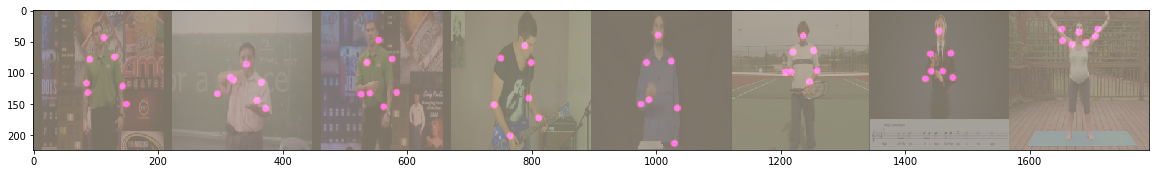

Epoch: 7  Train - Loss: 73.84 ; Validation - Loss: 64.72
Time consumed: 0:07:08.637851 Remaining time: 0:03:03.701936
80.59404098510743 200
76.9212981414795 400
75.25785537719726 600
74.85877872467042 800
73.97074240112305 1000
73.49024091084799 1200
73.77932423182897 1400
73.51780950546265 1600
73.51954618665907 1800
73.40499760437012 2000
73.49916220925071 2200
73.4070620727539 2400
73.48158609243539 2600
73.30635463169642 2800
73.2345719909668 3000
73.13257243156433 3200
73.24750858082491 3400
73.41451860215929 3600
73.66403110704924 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


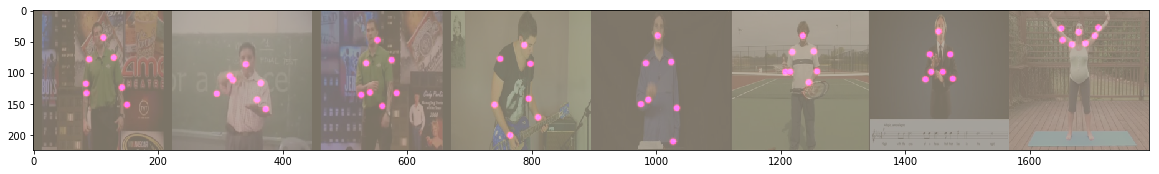

Epoch: 8  Train - Loss: 73.45 ; Validation - Loss: 64.55
Time consumed: 0:08:32.902661 Remaining time: 0:02:08.225665
76.24324569702148 200
74.95002548217774 400
73.9184955851237 600
73.68076175689697 800
73.74171362304688 1000
74.04376373291015 1200
74.59855586460658 1400
73.97488069534302 1600
73.85661275227865 1800
74.3888742980957 2000
74.04504727450283 2200
74.08273825327555 2400
73.95842012845553 2600
74.00094257899693 2800
73.77413452148437 3000
73.65138948440551 3200
73.77214072732365 3400
73.93138423495823 3600
73.72375735634252 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


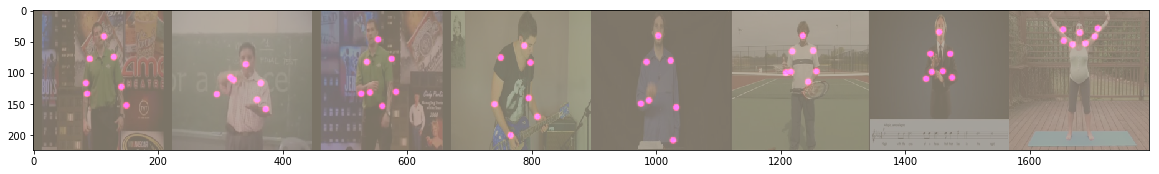

Epoch: 9  Train - Loss: 73.54 ; Validation - Loss: 64.54
Time consumed: 0:10:13.110620 Remaining time: 0:01:08.123402
77.59118515014649 200
75.36593193054199 400
74.49170873006184 600
73.79852523803712 800
73.90867700195312 1000
73.95659535725912 1200
73.80391745431082 1400
73.35762136459351 1600
73.45874498155382 1800
73.56346159362793 2000
73.61216566606001 2200
73.703135693868 2400
73.37415136483999 2600
73.42535095214843 2800
73.44979322306315 3000
73.36526861190796 3200
73.31263523774989 3400
73.30754778544109 3600
73.42137338738692 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


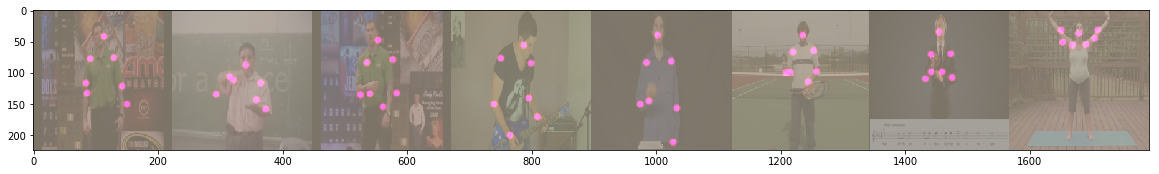

Epoch: 10  Train - Loss: 73.28 ; Validation - Loss: 64.23
Time consumed: 0:11:53.606505 Remaining time: 0:00:00


In [73]:
num_epoch=10

time_begin=time.time()

for epoch in range(num_epoch):
    scheduler.step()
    epoch_loss=train(pose_detection,trainloader,loss_fn,optimizer)
    val_loss  =test(pose_detection,valloader,loss_fn,optimizer)
    print('Epoch:',epoch+1, ' Train - Loss: {:.2f} ; Validation - Loss: {:.2f}'.format(epoch_loss,val_loss))
    l_t.append(epoch_loss)
    l_v.append(val_loss)
    now=time.time()
    time_used=now-time_begin
    time_remain= time_used /(epoch+1) *(num_epoch-1-epoch)
    print("Time consumed:", datetime.timedelta(seconds=time_used), "Remaining time:", datetime.timedelta(seconds=time_remain))
    
    

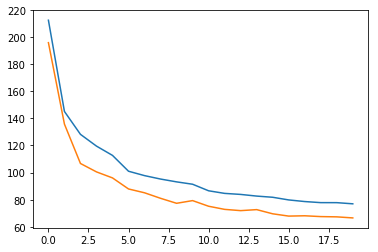

In [72]:
plt.plot(range(len(l_t)),l_t,l_v)

In [58]:
torch.save(pose_detection,"/home/tete/data/model")

/home/tete/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Regressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [56]:
pose_detection.train(False)    
preds = pose_detection(inputs_try.cuda()).cpu()
print(preds.shape)
print(labels_try.shape)

torch.Size([8, 7, 2])
torch.Size([8, 7, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


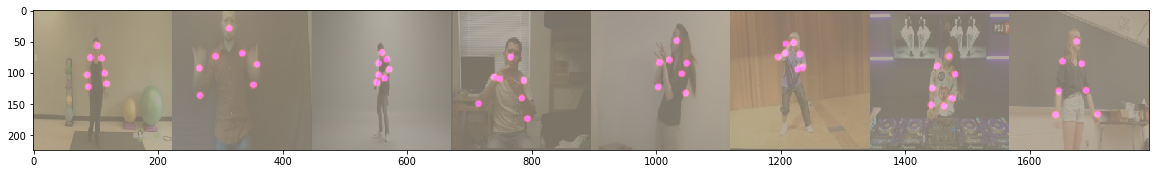

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


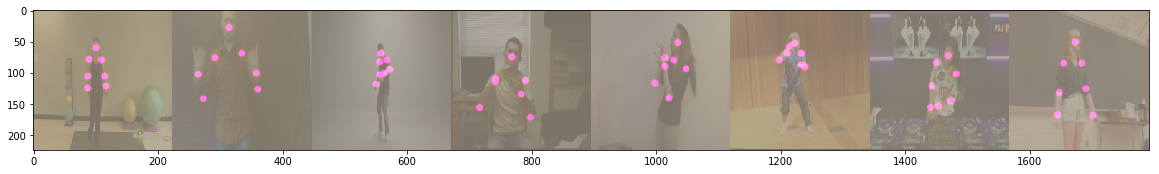

In [57]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,[224,224],preds) 
imshow(out,[224,224],labels_try)

In [ ]:
def train(model,trainloader,loss_fn,optimizer,n_epochs=10):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    optimizer = optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    for epoch_num in range(n_epochs):
        scheduler.step()
        running_corrects = 0.0
        running_loss = 0.0
        size = 0
        for data in trainloader:
            inputs, labels = data
            bs = labels.size(0)
            
            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()
            
            
            outputs = model(inputs)
            #print(outputs.shape, labels.shape)
            loss = loss_fn(outputs,labels) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #running_loss+=loss.data.item()
            #_,preds = torch.max(outputs.data,1)
            preds=outputs.data
            # statistics
            running_loss += loss.data.item()
            #print(preds.shape,labels.shape)
            #running_corrects += torch.sum(preds == labels)
            
            #if(size%int(len(data_loader)/3)==0 and size!=0):
            #    print(running_loss / size, size)
            size += bs
              
            
        epoch_loss = running_loss / size
        #epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        #acc_train[epoch_num] = epoch_acc
        print('Epoch: ',epoch_num+1,'/',n_epochs,' Train - Loss: {:.4f}'.format(epoch_loss))
        
    return loss_train#, acc_train